# Sketch Colorization using Residual UNets and ACGAN

### Adapted from:

[Style Transfer for Anime Sketches
with Enhanced Residual U-net and Auxiliary Classifier GAN
](https://arxiv.org/pdf/1706.03319v2.pdf)

## Imports

TODO: cleanup unused imports.

In [ ]:
import keras
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, MaxPooling2D, Add, Reshape, UpSampling2D, Dropout, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from google.colab import files

Using TensorFlow backend.


## Kaggle Things

Dataset: [Anime Sketch Colorization Pair]( https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair)

Using Kaggle API JSON.

Only unzipping training data. Most of the data in *data/training/* is reformatted to JSON in *data/colorgram/*, that directory is ignored. As is *data/data/* which also seems to hold the same images. The validation set in *data/val/* is also left out. 

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

100% 11.6G/11.6G [04:44<00:00, 26.8MB/s]
100% 11.6G/11.6G [04:44<00:00, 43.9MB/s]


In [ ]:
! unzip /content/anime-sketch-colorization-pair.zip -x "data/data/*" "data/val/*" "data/colorgram/*"

Streaming output truncated to the last 5000 lines.
  inflating: data/train/2564079.png  
  inflating: data/train/2564096.png  
  inflating: data/train/2564099.png  
  inflating: data/train/2564122.png  
  inflating: data/train/2564138.png  
  inflating: data/train/2564145.png  
  inflating: data/train/2564146.png  
  inflating: data/train/2565003.png  
  inflating: data/train/2565030.png  
  inflating: data/train/2565039.png  
  inflating: data/train/2565048.png  
  inflating: data/train/2565060.png  
  inflating: data/train/2565061.png  
  inflating: data/train/2565064.png  
  inflating: data/train/2565087.png  
  inflating: data/train/2565114.png  
  inflating: data/train/2565116.png  
  inflating: data/train/2565128.png  
  inflating: data/train/2565143.png  
  inflating: data/train/2566000.png  
  inflating: data/train/2566021.png  
  inflating: data/train/2566024.png  
  inflating: data/train/2566040.png  
  inflating: data/train/2566055.png  
  inflating: data/train/2566074.png  

## Wrangling the Dataset

The training set consists of 14224 images of size 256 x 512 x 3.

The colored images and sketches are arrayed side by side:

![alt text](https://drive.google.com/uc?id=15lE5LSjRN3xdSjYgexaZK4T6abBYLC-L)

### The preprocessing:

1. Creating a tensorflow dataset object
2. Reading and decoding the images
3. Casting the resulting arrays to float
4. Splitting in half horizontally (axis=1)
5. Normalization and resizing
6. Batching

A batch size of 20 is used as it is the biggest that can fit onro a Tesla K80 while using the simple unet generator. Using the bigger UNet with the VGG residual will relegate us to even smaller batch sizes.

> Furthermore, due to the
large quantity of layers in our residual network, the batch
size during training is limited to no more than 4.

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 640
EPOCHS = 2
SETS = 15

In [ ]:
dataset_path = glob.glob('/content/data/train/*.png')
dataset = tf.data.Dataset.from_tensor_slices(dataset_path)

In [ ]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    # cast and normalize
    image = tf.cast(image, tf.float32)/127.5 - 1
    w = tf.shape(image)[1]
    w = w // 2
    # split
    label = image[:, :w, :]
    sketch = image[:, w:, :]
    # resize
    # not doing this causes issues down the road
    label = tf.image.resize(label, (256, 256))
    sketch = tf.image.resize(sketch, (256, 256))
    return label, sketch

In [ ]:
dataset = dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

In [ ]:
train_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Getting and prepping a VGG16 model for use

As mentioned in the paper I'm using the residuals from the fc1 layer of a VGG19 model pretrained on ImageNet data. To do that, we need to remove the softmax and the fc2 layers.

> Our network is capable of drawing on sketches according
to style maps given by users, depending on the classification
ability of the VGG. However, the pretrained VGG is for
ImageNet photograph classification, but not for paintings.
In the future, we will train a classification network only for
paintings to achieve better results.

In [ ]:
VGG = VGG19(include_top=True, weights="imagenet")
for layer in VGG.layers:
    layer.trainable = False
vgg_model = Model(inputs = VGG.input, outputs = VGG.get_layer("fc1").output)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Encoder unit for the UNet Generator

Two sets of Conv2D->BatchNorm->ReLU layers, the first of which are skip connected later. Also makes use of maxpooling to shrink the height and width dimensions by a factor of 2 by default.

The paper never explicitly tells which layer of the encoder was skip connected to which layer of the decoder. But the encoder block can be inferred by looking at the channels present in the skip connections.

Currently, the odd layers are being used as skip connections.

In [ ]:
def encoder_unit(input, filter, kernel=3, stride=(1, 1), pooling='max'):
    x = Conv2D(filter, kernel_size=kernel, strides=stride, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    skip = (x)
    x = Conv2D(filter, kernel_size=kernel, strides=stride, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if pooling=='max':
        x = MaxPooling2D()(x)
    return x, skip

## Decoder unit for the UNet Generator

Similar to the encoder this one also contains two sets of Conv2D->BatchNorm->ReLU layers. By default, upsamples the input by a factor of 2. 

Output gets concatenated with the skip connection created in the encoder and later passed in, allowing it to become a UNet.

In [ ]:
def decoder_unit(input, skip, filter, kernel=3, stride=(1, 1), upsample="upsample"):
    if upsample=='upsample':
        x = UpSampling2D()(input)
    elif upsample=='deconv':
        x = Conv2DTranspose(filter, kernel+2, strides=(stride[0]+1, stride[1]+1), padding='valid', output_padding=(1, 1))
    else:
        x = input
    x = Conv2D(filter, kernel, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filter, kernel, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([x, skip])
    return x

## The Residual UNet Generator Model

![alt](https://drive.google.com/uc?id=1S_JbwyFHX_Nqaw3vQvLXHreQzxnLaxUg)
The authors are pretty opaque about the actual structure of their generator. 

There is no information about the setup of their guide decoders nor how they were trained. At this time I haven't implemented either of the guides. 

The hyperparameters for this decoder and bottleneck are also different. There should be an intermediate layer between the VGG and the bottleneck to get an input of shape 8 x 8 x 2048. The bottleneck should also be of the same shape.

The filter sizes and strides of the convolution were not mentioned in the paper. Nor was the use of either upsampling or deconvolution in the decoder.

TODO: Preprocess sketches to grayscale.



In [ ]:
def generator_model():
    input1 = Input((256, 256, 3), name="content")
    input2 = Input((4096,), name="style")
    vgg = Reshape((1, 1, -1))(input2)
    vgg = UpSampling2D(size=(2, 2), name="up1")(vgg)

    """Start encoder"""
    x, skip1 = encoder_unit(input1, 16)
    x, skip2 = encoder_unit(x, 32)
    x, skip3 = encoder_unit(x, 64)
    x, skip4 = encoder_unit(x, 128)
    x, skip5 = encoder_unit(x, 256)
    """end encoder"""

    # bottleneck
    # TODO: fix scaling-get 8x8x2048 somehow
    # maybe add another layer to vgg and retrain
    x = Reshape((2, 2, 4096))(x)
    x = Add(name="add")([x, vgg])
    x = Reshape((8, 8, 256))(x)

    """start decoder""" 
    x = decoder_unit(x, skip5, 256)
    x = decoder_unit(x, skip4, 128)
    x = decoder_unit(x, skip3, 64)
    x = decoder_unit(x, skip2, 32)
    x = decoder_unit(x, skip1, 16)
    """end decoder"""

    x = Conv2D(3, 3, strides=(1, 1), padding='same', name='final_c')(x)
    x = BatchNormalization(name='final_bn')(x)
    x = Activation('tanh', name='final_tanh')(x)
    
    return Model(inputs=[input1, input2], outputs=x, name='UNet')

## A Simple UNet Generator

This is a simple UNet model I made as a way to check if things are actually working. 

### Consists of:

- 4 encoder blocks skip connected to the decoders

- 4 decoder blocks 

- no bottleneck layers

In [ ]:
def simple_unet():
    input1 = Input((256, 256, 3))
    x, skip1 = encoder_unit(input1, 16)
    x, skip2 = encoder_unit(x, 32)
    x, skip3 = encoder_unit(x, 64)
    x, skip4 = encoder_unit(x, 128)
    x = decoder_unit(x, skip4, 128)
    x = decoder_unit(x, skip3, 64)
    x = decoder_unit(x, skip2, 32)
    x = decoder_unit(x, skip1, 16)
    x = Conv2D(3, 3, strides=(1, 1), padding='same')(x)
    return Model(inputs=input1, outputs=x)

## DCGAN Discriminator

A simple copy paste from [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan).

Might not be the best discriminator for the purpose. Using an ACGAN with 4096 outputs that correspond to the VGG19 models fc1 outputs would be better but would require greater VRAM and compute time:

> We finally integrate AC-GAN and our discriminator has exactly
4096 outputs, which will all be minimized to 0 when the
input is fake and approach to the same value of VGG 19’s
fc1 when the input is real in fig. 3.

> Unfortunately, to minimize the loss, it requires a large
memory size in GPU. We also employed the traditional discriminator of DCGAN for fast speed and large batch size


TODO: checkout how LeakyReLU holds up.

In [ ]:
def discriminator_model():
    input1 = Input((256, 256, 3))
    x = Conv2D(64, (5, 5), strides=(2, 2), padding="same")(input1)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=input1, outputs=x, name='discrim')
    return model

## Loss Functions

~~Tensorflow doesn't seem to have an inbuilt l1 loss function, so it has been implemented here.~~ I am stupid(didn't look for MAE loss).


## According to the Paper:
- The discriminator loss would be: 

    > LGAN (V, Gf , D) = Ey∼Pdata(y)
[Log(D(y))]+
Ex∼Pdata(x)
[Log(1 − D(Gf (x, V (x))))]

- The generator loss would be:

    > Ll1(V, Gf,g1,g2
) = Ex,y∼Pdata(x,y)
[||y − Gf (x, V (x))||1+
α||T(y) − Gg1
(x)||1 + β||y − Gg2
(x, V (x))||1]

    where T(y) is the grayscale mapping of the label y.


Since neither guide decoders have been implemented the full version of the above generator loss cannot be implemented as is. So the total generator loss is taken as the sum of the l1 loss between the generated output and the label and the crossentropy loss of the discriminator output.

In [ ]:
cross_entropy = BinaryCrossentropy(from_logits=True)
l1_loss = MeanAbsoluteError()

In [ ]:
def discriminator_loss(y_true, y_generated):
    real_loss = cross_entropy(tf.ones_like(y_true), y_true)
    fake_loss = cross_entropy(tf.zeros_like(y_generated), y_generated)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
LAMBDA = 10

In [ ]:
def generator_loss(y_true, y_generated, disc_gen_out, guide1 = None, guide2 = None, a = 0.3, b = 0.9):
    gan = cross_entropy(tf.ones_like(disc_gen_out), disc_gen_out)
    l1 = l1_loss(y_true, y_generated)
    total = l1 * LAMBDA + gan
    return total, l1, gan
    # l1 = l1_loss(y_true, y_generated) + a * l1_loss(to_grayscale(y_true, guide1)) + b * l1_loss(y_true, guide2)
    # return l1 * LAMBDA + gan

## Onto Training

An implementation of the GAN training algorithm.

~~Currently uses the simple UNet generator and the DCGAN discriminator.~~

~~TODO: make a different train step function for residual Unet.~~

Added a function to preprocess the labels before feeding into the VGG.

Moved around the calls for display.


In [ ]:
discriminator = discriminator_model()
generator = generator_model()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.75)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.75)

In [ ]:
checkpoint_dir = '/content/checkpoints'
checkpoint = tf.train.Checkpoint(discriminator=discriminator, 
                                 generator=generator, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator_optimizer=generator_optimizer)  
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)  

In [ ]:
def vgg_preprocess(image):
    image = image[ : , :224, :224, : ]
    # undoing normalization and rescaling to 0..1
    image = (image + 1) / 2
    image = preprocess_input(image)
    return image

In [ ]:
@tf.function
def train_step(labels, sketches):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        vgg_output = vgg_model(vgg_preprocess(labels), training=False)
        generated_images = generator([sketches, vgg_output], training=True)
        
        real_outputs = discriminator(labels, training=True)
        fake_outputs = discriminator(generated_images, training=True)

        gen_loss_total, gen_loss_l1, gen_loss_gan = generator_loss(labels, generated_images, fake_outputs)
        disc_loss = discriminator_loss(real_outputs, fake_outputs)

    gradients_of_generator = gen_tape.gradient(gen_loss_total, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def fit(train_dataset, epochs):
    for epoch in range(epochs):
        print("Epoch: " + str(epoch + 1))
        named_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", named_tuple)
        print("Started: " + time_string)
        for n, (labels, sketches) in train_dataset.enumerate():
            train_step(labels, sketches)
        named_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", named_tuple)
        print("Ended: " + time_string)

In [ ]:
def display(label, sketch, output):
    images = [label[0], sketch[0], output[0]]
    plt.figure(figsize = (15, 15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

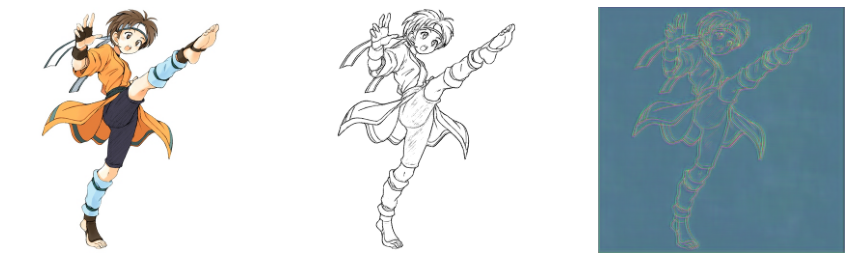

In [ ]:
for labels, sketches in train_dataset.take(1):
    vgg_out = vgg_model.predict(vgg_preprocess(labels))
    imgs = generator([sketches, vgg_out], training = False)
    display(labels, sketches, imgs)

In [ ]:
def train():
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    for i in range(SETS):
        print("Set: " + str(i + 1))
        fit(train_dataset, EPOCHS)
        path = manager.save()
        print("Checkpoint saved at {}".format(checkpoint_dir))
        for labels, sketches in train_dataset.take(1): 
            vgg_out = vgg_model.predict(vgg_preprocess(labels))
            imgs = generator([sketches, vgg_out], training = False)
            display(labels, sketches, imgs)

Restored from /content/checkpoints/ckpt-1
Set: 1
Epoch: 1
Started: 07/23/2020, 08:47:03
Ended: 07/23/2020, 08:50:12
Epoch: 2
Started: 07/23/2020, 08:50:12
Ended: 07/23/2020, 08:53:20
Checkpoint saved at /content/checkpoints


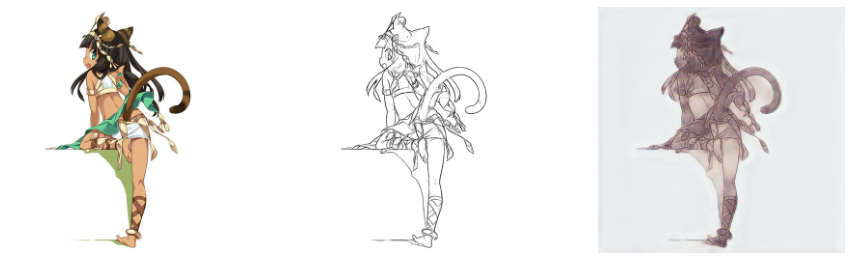

Set: 2
Epoch: 1
Started: 07/23/2020, 08:53:27
Ended: 07/23/2020, 08:56:35
Epoch: 2
Started: 07/23/2020, 08:56:35
Ended: 07/23/2020, 08:59:44
Checkpoint saved at /content/checkpoints


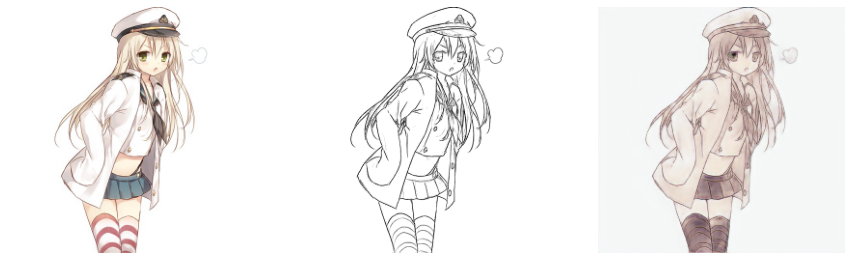

Set: 3
Epoch: 1
Started: 07/23/2020, 08:59:50
Ended: 07/23/2020, 09:02:59
Epoch: 2
Started: 07/23/2020, 09:02:59
Ended: 07/23/2020, 09:06:08
Checkpoint saved at /content/checkpoints


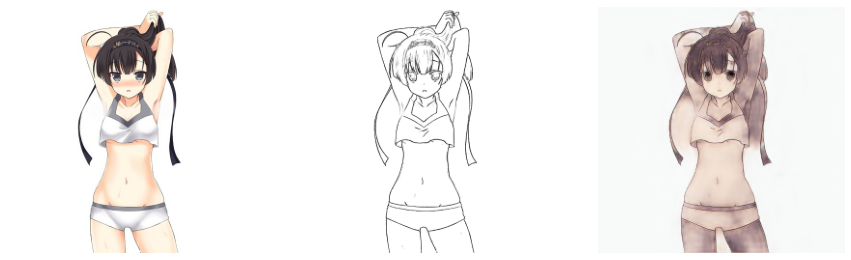

Set: 4
Epoch: 1
Started: 07/23/2020, 09:06:15
Ended: 07/23/2020, 09:09:23
Epoch: 2
Started: 07/23/2020, 09:09:23
Ended: 07/23/2020, 09:12:32
Checkpoint saved at /content/checkpoints


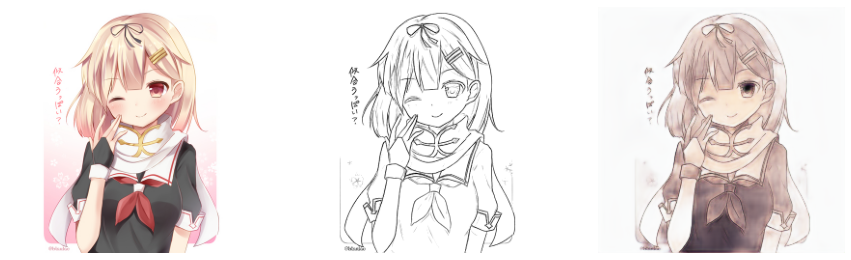

Set: 5
Epoch: 1
Started: 07/23/2020, 09:12:39
Ended: 07/23/2020, 09:15:47
Epoch: 2
Started: 07/23/2020, 09:15:47
Ended: 07/23/2020, 09:18:55
Checkpoint saved at /content/checkpoints


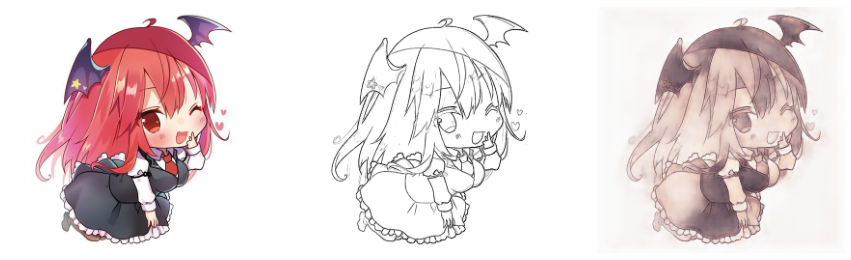

Set: 6
Epoch: 1
Started: 07/23/2020, 09:19:02
Ended: 07/23/2020, 09:22:11
Epoch: 2
Started: 07/23/2020, 09:22:11
Ended: 07/23/2020, 09:25:19
Checkpoint saved at /content/checkpoints


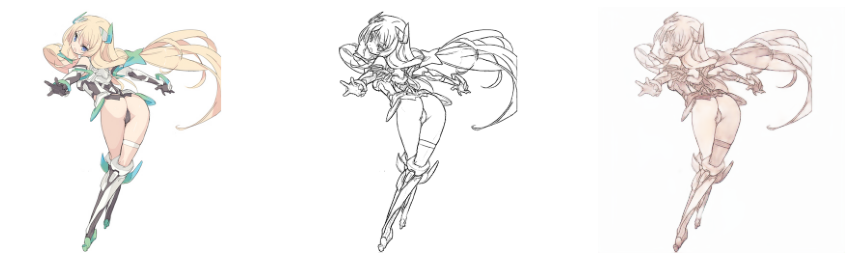

Set: 7
Epoch: 1
Started: 07/23/2020, 09:25:25
Ended: 07/23/2020, 09:28:34
Epoch: 2
Started: 07/23/2020, 09:28:34
Ended: 07/23/2020, 09:31:42
Checkpoint saved at /content/checkpoints


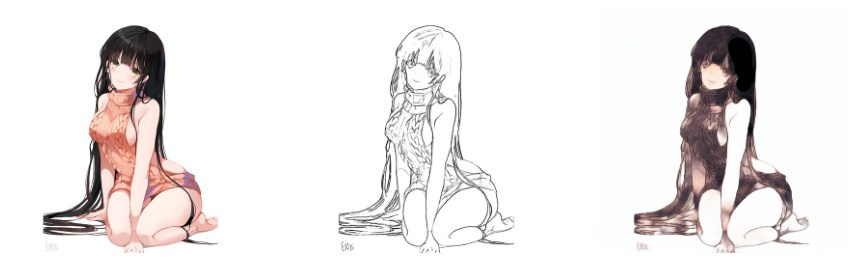

Set: 8
Epoch: 1
Started: 07/23/2020, 09:31:48
Ended: 07/23/2020, 09:34:57
Epoch: 2
Started: 07/23/2020, 09:34:57
Ended: 07/23/2020, 09:38:05
Checkpoint saved at /content/checkpoints


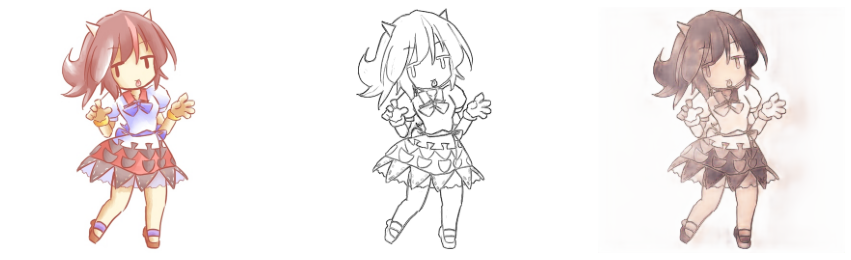

Set: 9
Epoch: 1
Started: 07/23/2020, 09:38:12
Ended: 07/23/2020, 09:41:21
Epoch: 2
Started: 07/23/2020, 09:41:21
Ended: 07/23/2020, 09:44:29
Checkpoint saved at /content/checkpoints


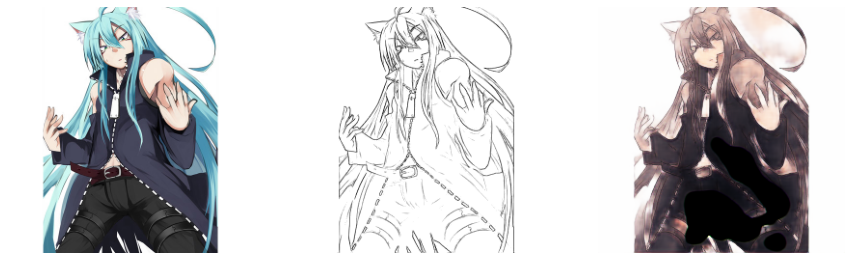

Set: 10
Epoch: 1
Started: 07/23/2020, 09:44:36
Ended: 07/23/2020, 09:47:44
Epoch: 2
Started: 07/23/2020, 09:47:44
Ended: 07/23/2020, 09:50:53
Checkpoint saved at /content/checkpoints


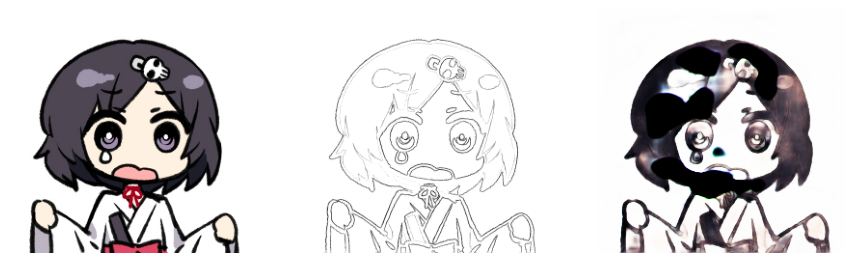

Set: 11
Epoch: 1
Started: 07/23/2020, 09:50:59
Ended: 07/23/2020, 09:54:08
Epoch: 2
Started: 07/23/2020, 09:54:08
Ended: 07/23/2020, 09:57:17
Checkpoint saved at /content/checkpoints


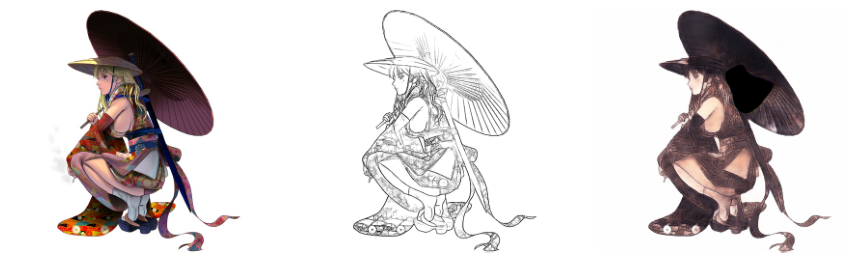

Set: 12
Epoch: 1
Started: 07/23/2020, 09:57:23
Ended: 07/23/2020, 10:00:32
Epoch: 2
Started: 07/23/2020, 10:00:32
Ended: 07/23/2020, 10:03:40
Checkpoint saved at /content/checkpoints


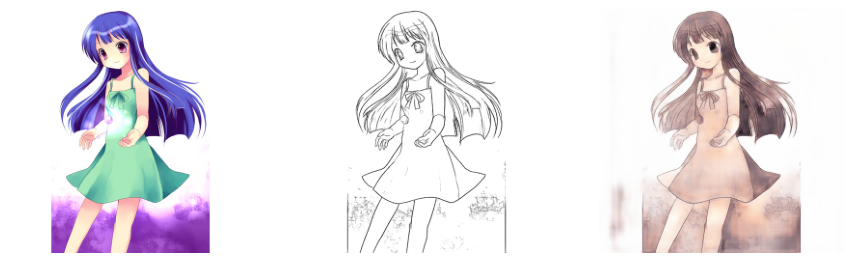

Set: 13
Epoch: 1
Started: 07/23/2020, 10:03:47
Ended: 07/23/2020, 10:06:56
Epoch: 2
Started: 07/23/2020, 10:06:56
Ended: 07/23/2020, 10:10:05
Checkpoint saved at /content/checkpoints


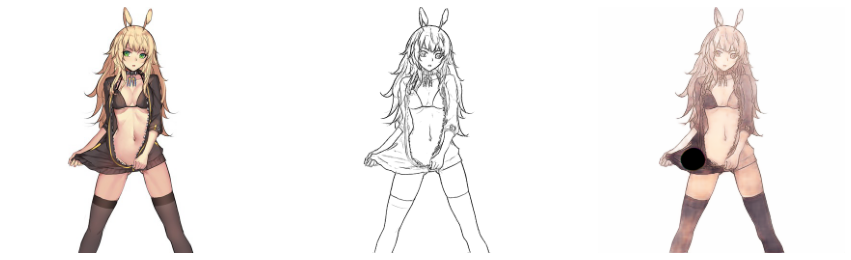

Set: 14
Epoch: 1
Started: 07/23/2020, 10:10:11
Ended: 07/23/2020, 10:13:20
Epoch: 2
Started: 07/23/2020, 10:13:20
Ended: 07/23/2020, 10:16:28
Checkpoint saved at /content/checkpoints


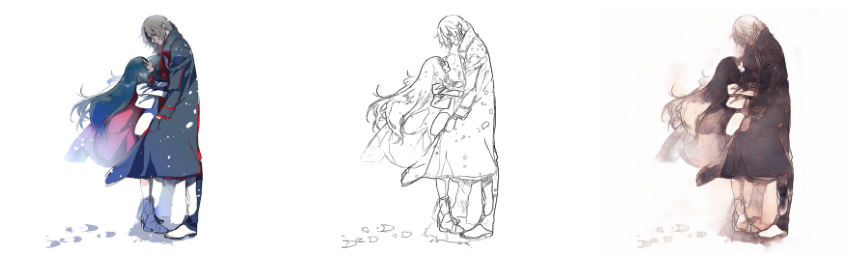

Set: 15
Epoch: 1
Started: 07/23/2020, 10:16:34
Ended: 07/23/2020, 10:19:43
Epoch: 2
Started: 07/23/2020, 10:19:43
Ended: 07/23/2020, 10:22:51
Checkpoint saved at /content/checkpoints


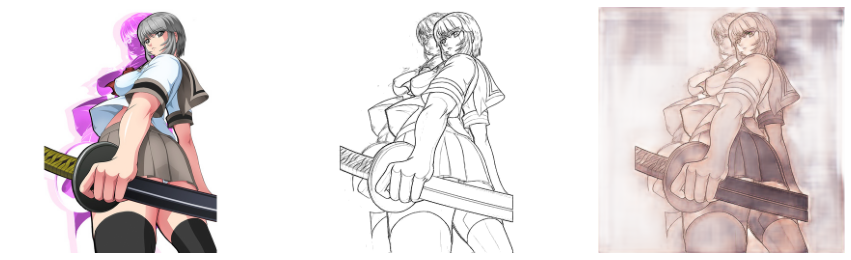

In [ ]:
train()

In [ ]:
!nvidia-smi

Thu Jul 23 10:22:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    43W / 250W |   8867MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Saving Models

~~TODO: figure out why downloading this way takes soo long~~

In [ ]:
! zip -r sc_v1_ckpt.zip '/content/checkpoints'

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/ckpt-14.data-00001-of-00002 (deflated 9%)
  adding: content/checkpoints/ckpt-16.data-00000-of-00002 (deflated 89%)
  adding: content/checkpoints/ckpt-15.index (deflated 80%)
  adding: content/checkpoints/ckpt-15.data-00001-of-00002 (deflated 8%)
  adding: content/checkpoints/ckpt-14.data-00000-of-00002 (deflated 89%)
  adding: content/checkpoints/ckpt-16.data-00001-of-00002 (deflated 9%)
  adding: content/checkpoints/checkpoint (deflated 63%)
  adding: content/checkpoints/ckpt-16.index (deflated 80%)
  adding: content/checkpoints/ckpt-15.data-00000-of-00002 (deflated 89%)
  adding: content/checkpoints/ckpt-14.index (deflated 80%)


In [38]:
files.download('sc_v1_ckpt.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>